In [11]:
from sys import getsizeof
import xarray as xr
from glob import glob
import xmitgcm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
import os
from pathlib import Path
from xmitgcm import open_mdsdataset
import seaborn as sns
import pandas as pd
from datetime import datetime,timedelta
from scipy.interpolate import griddata

import matplotlib.animation
from IPython.display import HTML

import xarray.ufuncs as xu
from scipy.interpolate import Rbf

from scipy.ndimage import gaussian_filter

from IPython.display import Image

from cmocean import cm

import matplotlib.patheffects as PathEffects


In [15]:
path = '../run'
merge = False

In [16]:
topog = np.fromfile('../input/BAT.bin',dtype='>f8').astype('float64')
topog = topog.reshape(42,80)

In [17]:
%%time


if merge:
    datas = {}

    for run in ['N0','NC','NZ']:
        dsets = []

        for i in range(1,4+1):
            fnames = glob(os.path.join(path+'_{}'.format(run),"MNC_*/state*{}.nc".format(i)))
            fnames.sort()
            di = xr.open_mfdataset(fnames,combine='by_coords',concat_dim='T')
            di = di.assign({
                'U':di.U.interp(Xp1=di.X),
                'V':di.V.interp(Yp1=di.Y),
                'W':di.W.interp(Zl=di.Z),
            }).drop(['Xp1','Yp1','Zl','iter'])
            dsets.append(di)

        data = xr.combine_nested([xr.combine_nested([dsets[0],dsets[1]],concat_dim='X'),
                                  xr.combine_nested([dsets[2],dsets[3]],concat_dim='X')],
                                 concat_dim='Y')


        data = data.assign({
            'Zeta':((data.V.differentiate('X')-data.U.differentiate('Y'))/2).rename('Zeta'),
            'Strain':(((
            (data.U.differentiate('X')-data.V.differentiate('Y'))**2+\
            (data.U.differentiate('Y')+data.V.differentiate('X'))**2
            )**(1/2))/2
        ).rename('Strain'),
            'Topog':xr.DataArray(topog,dims=['Y','X']),
        })

        data = data.assign({
            'Dens':(('T','Z','Y','X'),sw.pden(35*np.ones(data.Temp.shape),data.Temp.values,
                           -data.Z.values[None,:,None,None]*np.ones(data.Temp.shape)))
        })

        with xr.set_options(keep_attrs=True):
            data = data.assign_coords({'T':data.T-data.T[0]})

        data.Zeta.attrs['units'] = 's$^{-1}$'
        data.Zeta.attrs['long_name'] = 'Relative Vorticity'

        data.Strain.attrs['units'] = 's$^{-1}$'
        data.Strain.attrs['long_name'] = 'Strain Rate'

        data.Topog.attrs['units'] = 'm'
        data.Topog.attrs['long_name'] = 'Topography'

        data.Dens.attrs['units'] = 'kg$\,$m$^{-3}$'
        data.Dens.attrs['long_name'] = 'Potential Density'

        data.sel(T=slice(0,5*86400)).to_netcdf('../../../../../../data/gaussian_bump/topo_bump_{}.nc'.format(run))

        datas[run] = data

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [53]:
datas = {}
for run in ['N0','NC','NZ']:
    datas[run] = xr.open_dataset('../../../../../../data/gaussian_bump/topo_bump_{}.nc'.format(run))

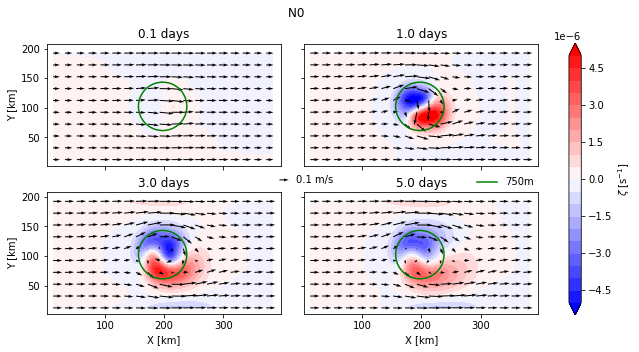

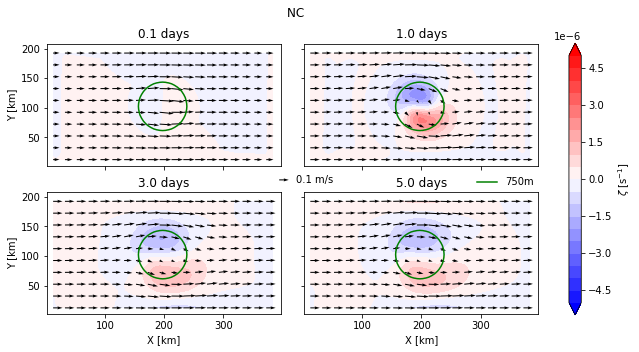

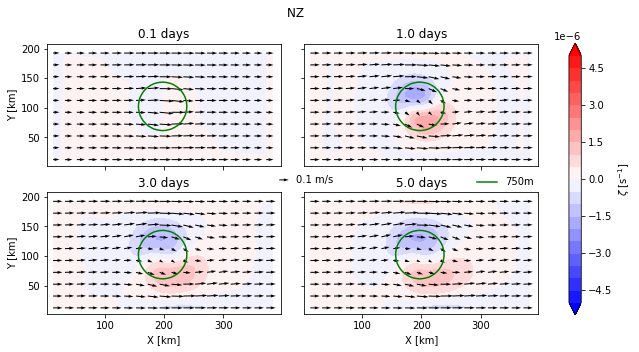

In [55]:
vm = 0.5e-5

kw = dict(
    contourf=dict(add_colorbar=False,
                  vmin=-vm,
                  vmax=vm,
                  levels=np.arange(-vm,vm,0.05e-5),
                  cmap='bwr',
                  extend='both',
                 )
)

kw['subset'] = dict(Z=0,X=slice(2,-3),Y=slice(2,-3))

its = np.array([0.05,1,3,5])*86400

for run in ['N0','NC','NZ']:
    fig,ax = plt.subplots(2,2,figsize=(11,5))
    ax = np.ravel(ax)

    s = 4

    for i,it in enumerate(its):

        C = datas[run].Zeta.sel(T=it,method='nearest').isel(**kw['subset']).plot.contourf(ax=ax[i],**kw['contourf'])

        Q = ax[i].quiver(datas[run].isel(**kw['subset']).X.values[::s],
                  datas[run].isel(**kw['subset']).Y.values[::s],
                  datas[run].U.sel(T=it,method='nearest').isel(**kw['subset']).values[::s,::s],
                  datas[run].V.sel(T=it,method='nearest').isel(**kw['subset']).values[::s,::s])

        datas[run].Topog.plot.contour(ax=ax[i],linestyles='solid',colors='g',levels=[-750])

        ax[i].axis('scaled')
        ax[i].set(ylabel='',xlabel='',title='{:.1f} days'.format(datas[run].sel(T=it,method='nearest').T.values/86400))

    ax[i].plot([],[],'-g',label='750m')
    ax[i].legend(bbox_to_anchor=(0.7, 1.2),frameon=False,loc='upper left')
    fig.subplots_adjust(hspace=0.2,wspace=0.1)

    cbar = fig.colorbar(C,ax=ax)
    cbar.set_label('$\zeta$ [s$^{-1}$]')
    
    fig.suptitle(run+25*' ')

    qkey = ax[0].quiverkey(Q,0.43,0.5,0.1,'0.1 m/s',
                           coordinates='figure',labelpos='E')

    _ = [a.set(xticklabels=[]) for a in ax[[0,1]]]
    _ = [a.set(yticklabels=[]) for a in ax[[1,3]]]

    _ = [a.set(ylabel='Y [km]',yticklabels=a.get_yticks().astype('int')//1000) for a in ax[[0,2]]]
    _ = [a.set(xlabel='X [km]',xticklabels=a.get_xticks().astype('int')//1000) for a in ax[[2,3]]]
    
    depth = np.abs(datas[run].isel(Z=kw['subset']['Z']).Z.values)
    fig.savefig('./img/quiver_zeta_{:.0f}m_{}.png'.format(depth,run),dpi=300,bbox_inches='tight')

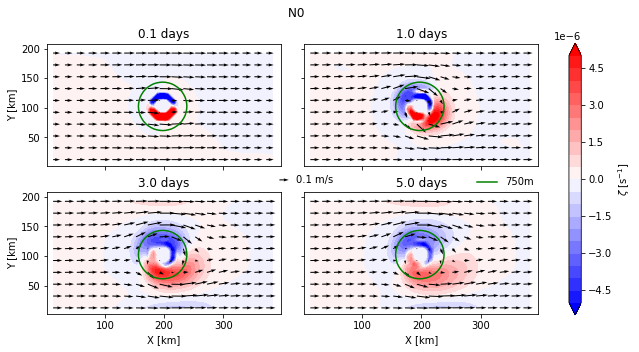

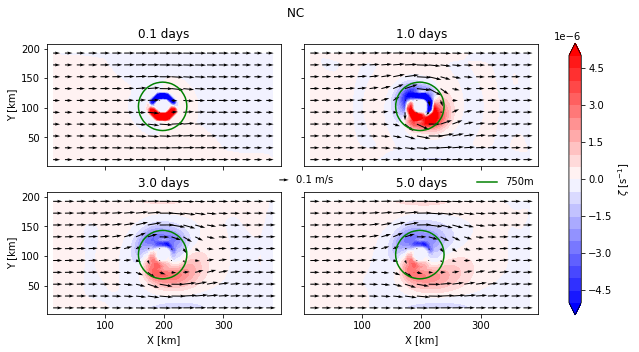

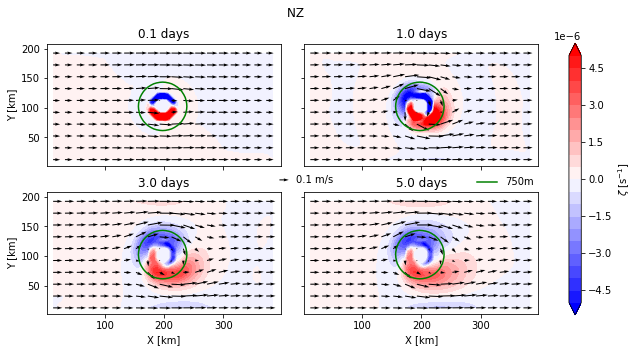

In [56]:
vm = 0.5e-5

kw = dict(
    contourf=dict(add_colorbar=False,
                  vmin=-vm,
                  vmax=vm,
                  levels=np.arange(-vm,vm,0.05e-5),
                  cmap='bwr',
                  extend='both',
                 )
)

kw['subset'] = dict(Z=20,X=slice(2,-3),Y=slice(2,-3))

its = np.array([0.05,1,3,5])*86400

for run in ['N0','NC','NZ']:
    fig,ax = plt.subplots(2,2,figsize=(11,5))
    ax = np.ravel(ax)

    s = 4

    for i,it in enumerate(its):

        C = datas[run].Zeta.sel(T=it,method='nearest').isel(**kw['subset']).plot.contourf(ax=ax[i],**kw['contourf'])

        Q = ax[i].quiver(datas[run].isel(**kw['subset']).X.values[::s],
                  datas[run].isel(**kw['subset']).Y.values[::s],
                  datas[run].U.sel(T=it,method='nearest').isel(**kw['subset']).values[::s,::s],
                  datas[run].V.sel(T=it,method='nearest').isel(**kw['subset']).values[::s,::s])

        datas[run].Topog.plot.contour(ax=ax[i],linestyles='solid',colors='g',levels=[-750])

        ax[i].axis('scaled')
        ax[i].set(ylabel='',xlabel='',title='{:.1f} days'.format(datas[run].sel(T=it,method='nearest').T.values/86400))

    ax[i].plot([],[],'-g',label='750m')
    ax[i].legend(bbox_to_anchor=(0.7, 1.2),frameon=False,loc='upper left')
    fig.subplots_adjust(hspace=0.2,wspace=0.1)

    cbar = fig.colorbar(C,ax=ax)
    cbar.set_label('$\zeta$ [s$^{-1}$]')
    
    fig.suptitle(run+25*' ')

    qkey = ax[0].quiverkey(Q,0.43,0.5,0.1,'0.1 m/s',
                           coordinates='figure',labelpos='E')

    _ = [a.set(xticklabels=[]) for a in ax[[0,1]]]
    _ = [a.set(yticklabels=[]) for a in ax[[1,3]]]

    _ = [a.set(ylabel='Y [km]',yticklabels=a.get_yticks().astype('int')//1000) for a in ax[[0,2]]]
    _ = [a.set(xlabel='X [km]',xticklabels=a.get_xticks().astype('int')//1000) for a in ax[[2,3]]]

    depth = np.abs(datas[run].isel(Z=kw['subset']['Z']).Z.values)
    fig.savefig('./img/quiver_zeta_{:.0f}m_{}.png'.format(depth,run),dpi=300,bbox_inches='tight')

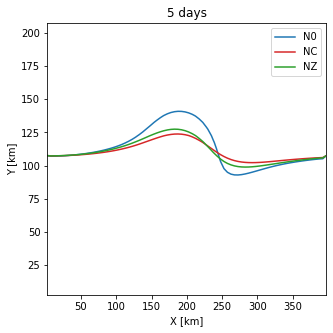

In [41]:
ti = 5

fig,ax = plt.subplots(figsize=(5,5))
for run,color in zip(['N0','NC','NZ'],['tab:blue','tab:red','tab:green']):
    datas[run].Eta.sel(T=ti*86400,method='nearest').plot.contour(levels=[0],colors=color,ax=ax)
    ax.plot([],[],color=color,label=run)
ax.legend()

_ = ax.set(
    title=f'{ti} days',
    xlabel='X [km]',xticklabels=ax.get_xticks().astype('int')//1000,
    ylabel='Y [km]',yticklabels=ax.get_yticks().astype('int')//1000,
)